In [292]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import scorecardpy as sc

import warnings
warnings.filterwarnings('ignore')

In [293]:
train = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\train.csv')
test = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\test.csv')
description = pd.read_excel('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\Data Dictionary.xls')
sample_sub = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\sample_submission.csv')

In [294]:
# Дропаем id
train.drop('Id', axis=1, inplace=True)

In [295]:
# Проверяем на дубликаты
train.duplicated().sum()

353

In [296]:
# Дропаем дубликаты
train.drop_duplicates(inplace=True, ignore_index=True)

In [297]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104452 entries, 0 to 104451
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      104452 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  104452 non-null  float64
 2   age                                   104452 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  104452 non-null  int64  
 4   DebtRatio                             104452 non-null  float64
 5   MonthlyIncome                         83959 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       104452 non-null  int64  
 7   NumberOfTimes90DaysLate               104452 non-null  int64  
 8   NumberRealEstateLoansOrLines          104452 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  104452 non-null  int64  
 10  NumberOfDependents                    101757 non-null  float64
dtype

In [298]:
# Нулевой возраст(невозможно), нулевой ежемесячный доход(возможно, но важно),
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,104452.000000,104452.000000,104452.000000,104452.000000,104452.000000,8.395900e+04,104452.000000,104452.000000,104452.000000,104452.000000,101757.000000
mean,0.066432,5.619242,52.364837,0.390275,356.053455,6.689040e+03,8.478210,0.233619,1.022996,0.209158,0.758267
std,0.249038,217.756704,14.725083,3.813994,2172.747226,1.565831e+04,5.120052,3.787095,1.137218,3.771295,1.113034
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029997,41.000000,0.000000,0.176965,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.153982,52.000000,0.000000,0.368022,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.557240,63.000000,0.000000,0.873129,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,29110.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,13.000000


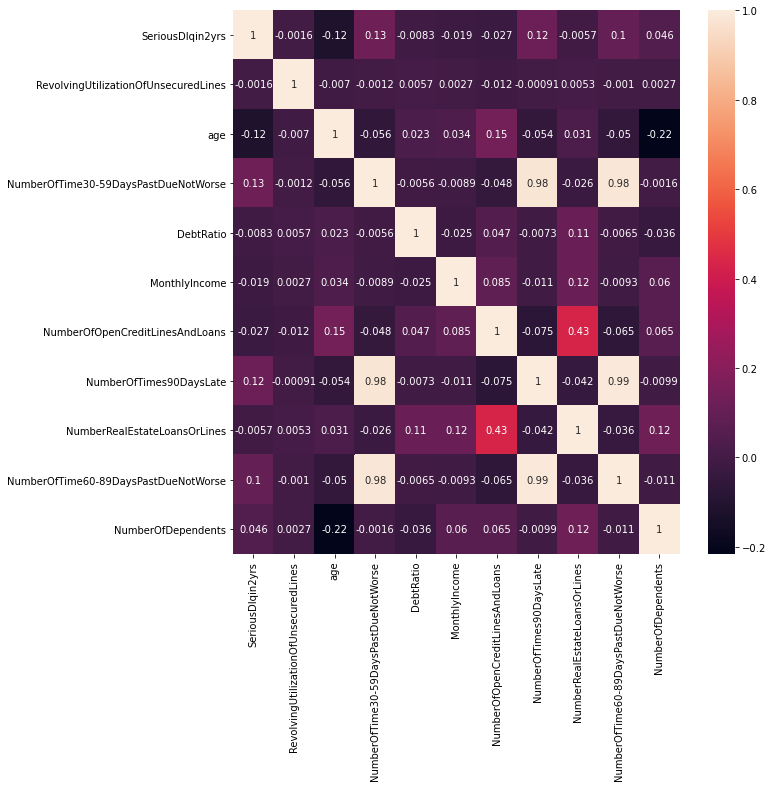

In [299]:
# Одна из предпосылок логистической регрессии - отсутствие мультиколлинеарности между предикторами
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True)

In [300]:
# Корреляция близкая к 1 у признаков - 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
# Так же у них присутствуют два невозможных значения - 98 и 96. Скорее всего эти значения не обозначают количество
train['NumberOfTimes90DaysLate'].value_counts()

0     98769
1      3601
2      1043
3       466
4       202
98      152
5        89
6        56
7        27
9        14
8        12
10        6
11        4
12        2
96        2
13        2
14        2
15        2
17        1
Name: NumberOfTimes90DaysLate, dtype: int64

Название признака - SeriousDlqin2yrs


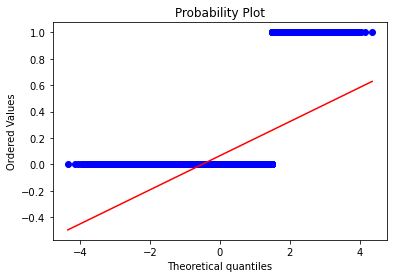

Название признака - RevolvingUtilizationOfUnsecuredLines


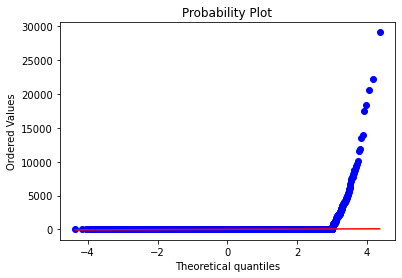

Название признака - age


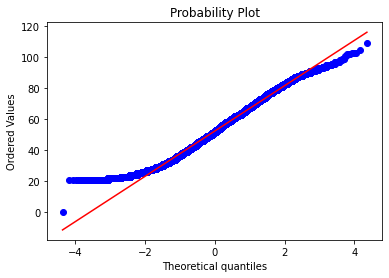

Название признака - NumberOfTime30-59DaysPastDueNotWorse


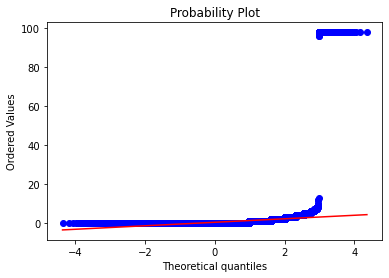

Название признака - DebtRatio


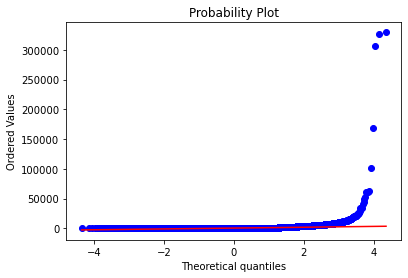

Название признака - MonthlyIncome


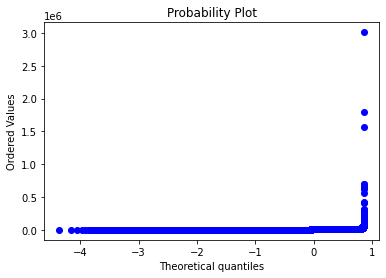

Название признака - NumberOfOpenCreditLinesAndLoans


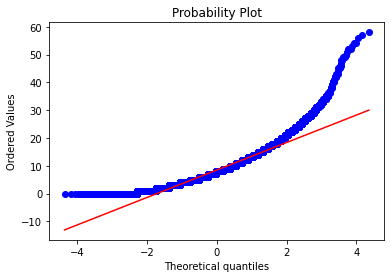

Название признака - NumberOfTimes90DaysLate


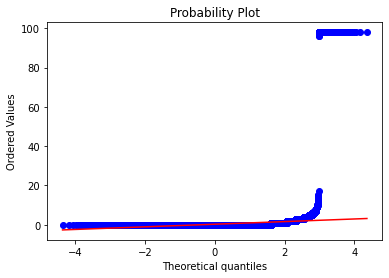

Название признака - NumberRealEstateLoansOrLines


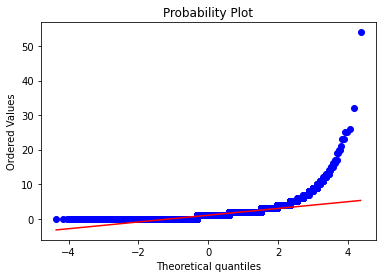

Название признака - NumberOfTime60-89DaysPastDueNotWorse


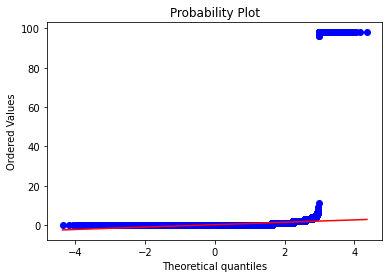

Название признака - NumberOfDependents


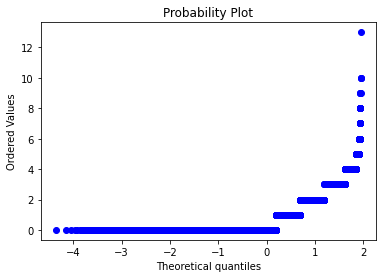

In [301]:
# Эти значения являются выбросами в том формате, в котором они находятся сейчас
for i in train.columns:
    print('Название признака -',i)
    plt.figure()
    stats.probplot(train[i], plot=plt)
    plt.show()

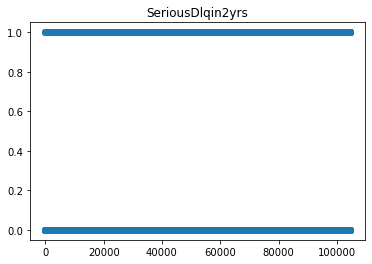

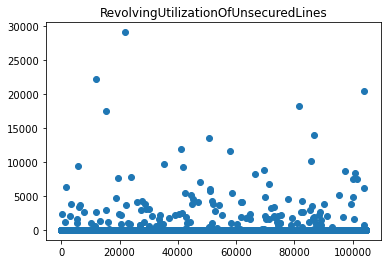

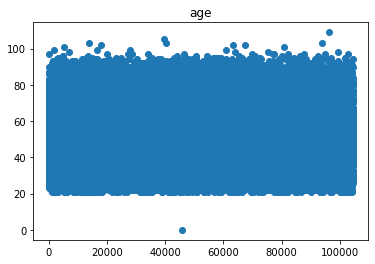

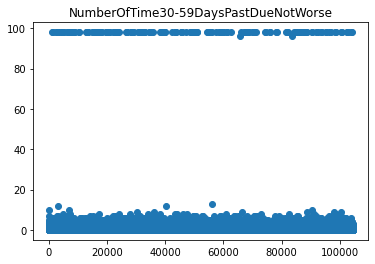

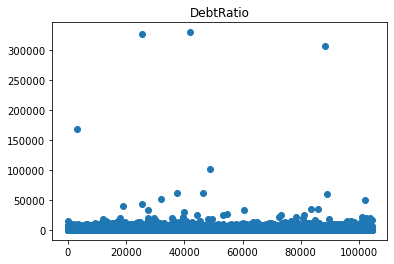

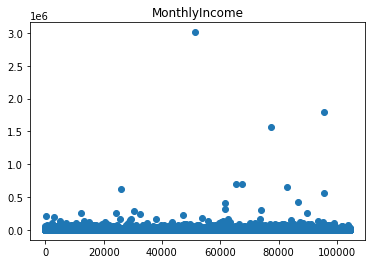

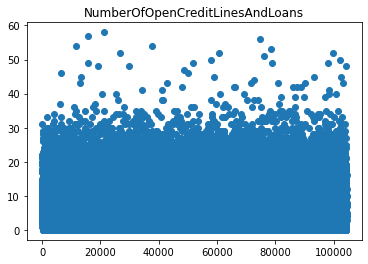

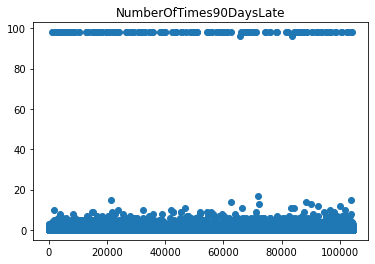

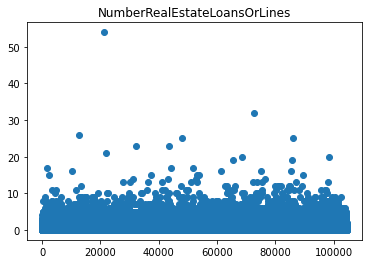

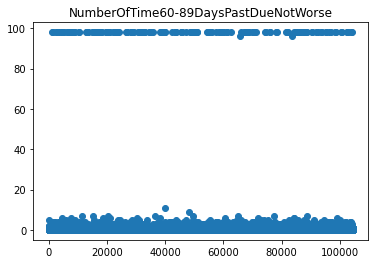

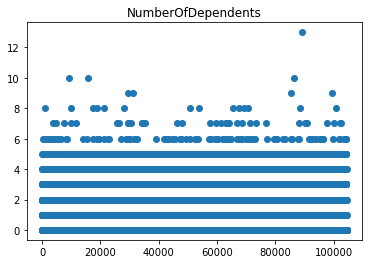

In [302]:
for i in train.columns:
    plt.figure()
    plt.title(i)
    plt.scatter(train.index, train[i])

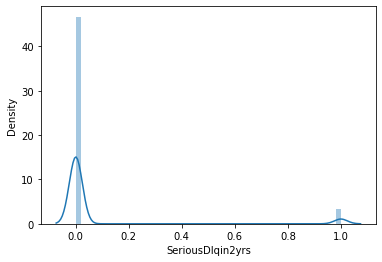

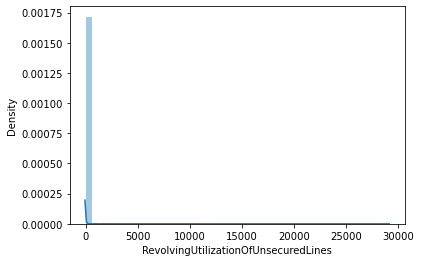

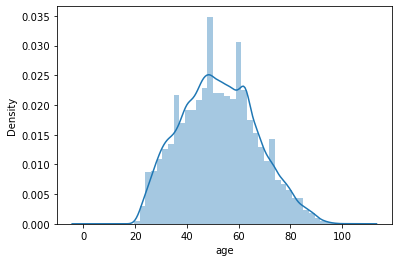

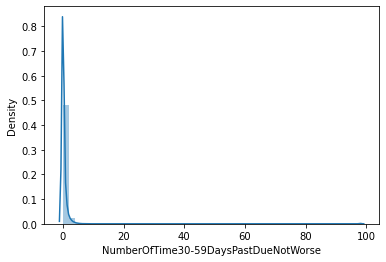

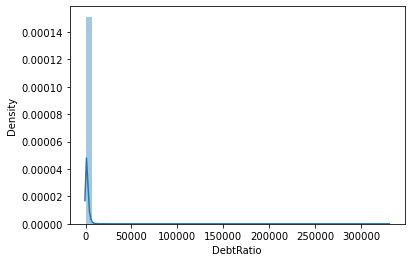

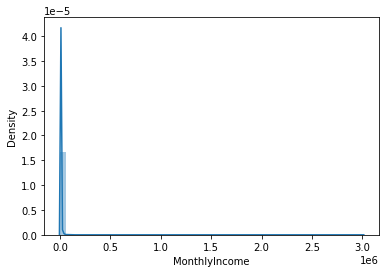

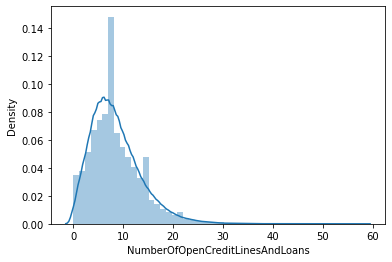

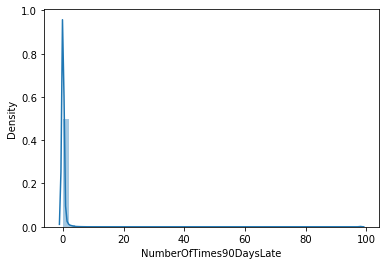

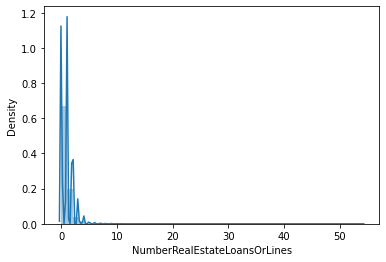

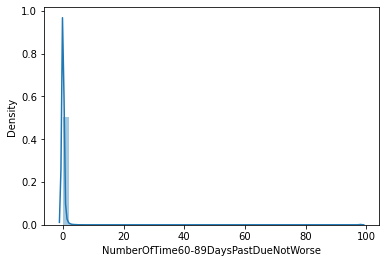

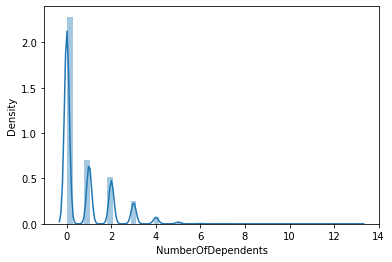

In [303]:
for i in train.columns:
    plt.figure()
    sns.distplot(train[i])

### Выбросы

In [304]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2695
dtype: int64

In [305]:
# Заменим выбросы на пропуски.
nan_feat = ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']

train[nan_feat] = np.where(train[nan_feat] > 20, np.nan, train[nan_feat])

In [306]:
# Нулевое значение в возрасте изменим на пропущенное
train.age = np.where(train.age == 0, np.nan, train.age)

In [307]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         1
NumberOfTime30-59DaysPastDueNotWorse      154
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   154
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      154
NumberOfDependents                       2695
dtype: int64

In [308]:
train.shape

(104452, 11)

### Feature Engineering(Биннинг на основе WoE)

 - Возвращение стандартизированной удаленной переменной в датасет
 - MonthlyIncome/NumberOfDependents
 - Приведение к нормальному распределению

In [309]:
train['money_on_dependent'] = np.where(train.NumberOfDependents > 0, train.MonthlyIncome / train.NumberOfDependents, train.MonthlyIncome)

In [310]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         1
NumberOfTime30-59DaysPastDueNotWorse      154
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   154
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      154
NumberOfDependents                       2695
money_on_dependent                      20493
dtype: int64

In [311]:
%%time
# Используем библиотеку scorecard. Фильтрация(отбор переменных)
data = sc.var_filter(train, y='SeriousDlqin2yrs')

[INFO] filtering variables ...
Variable filtering on 104452 rows and 12 columns in 00:03:42 
0 variables are removed
Wall time: 3min 42s


In [312]:
# Разбиваем данные для обучения и теста
new_train, new_test = sc.split_df(data, 'SeriousDlqin2yrs').values()

In [313]:
# Заполним пропущенные значения, так как с заполнением показывало лучшее качество
median_imp = ['age', 'NumberOfTime30-59DaysPastDueNotWorse',
              'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


si_median = SimpleImputer(strategy='median')
si_median.fit(new_train[median_imp])
new_train[median_imp] = si_median.transform(new_train[median_imp])
new_test[median_imp] = si_median.transform(new_test[median_imp])

In [314]:
si_mean = SimpleImputer(strategy='mean')
si_mean.fit(new_train[['MonthlyIncome']])

new_train.MonthlyIncome = si_mean.transform(new_train[['MonthlyIncome']])
new_test.MonthlyIncome = si_mean.transform(new_test[['MonthlyIncome']])

In [315]:
test.isna().sum()

Id                                         0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           8950
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1175
dtype: int64

[INFO] creating woe binning ...
Binning on 104452 rows and 12 columns in 00:00:15


{'money_on_dependent': <Figure size 432x288 with 2 Axes>,
 'NumberOfTimes90DaysLate': <Figure size 432x288 with 2 Axes>,
 'DebtRatio': <Figure size 432x288 with 2 Axes>,
 'RevolvingUtilizationOfUnsecuredLines': <Figure size 432x288 with 2 Axes>,
 'NumberOfTime60-89DaysPastDueNotWorse': <Figure size 432x288 with 2 Axes>,
 'MonthlyIncome': <Figure size 432x288 with 2 Axes>,
 'NumberOfDependents': <Figure size 432x288 with 2 Axes>,
 'NumberOfTime30-59DaysPastDueNotWorse': <Figure size 432x288 with 2 Axes>,
 'NumberRealEstateLoansOrLines': <Figure size 432x288 with 2 Axes>,
 'NumberOfOpenCreditLinesAndLoans': <Figure size 432x288 with 2 Axes>,
 'age': <Figure size 432x288 with 2 Axes>}

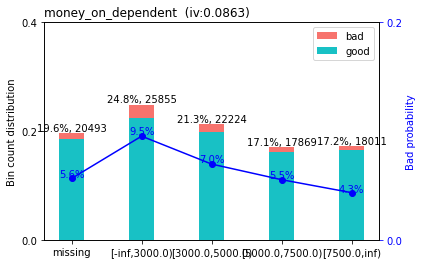

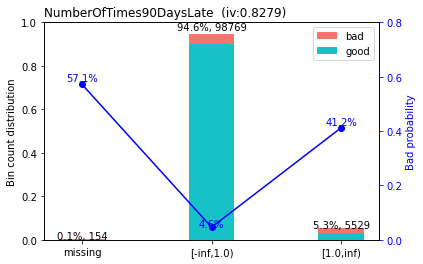

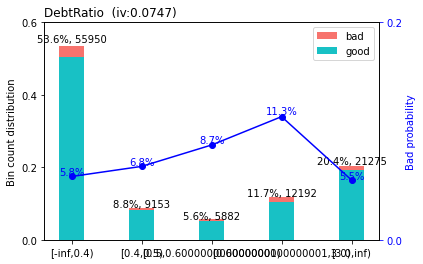

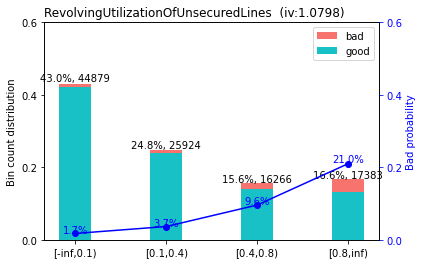

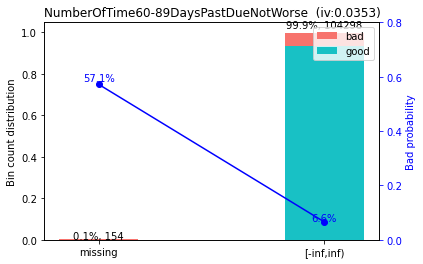

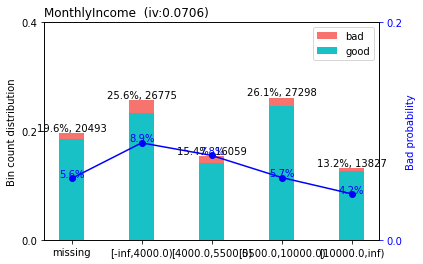

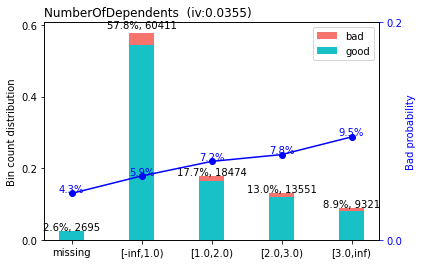

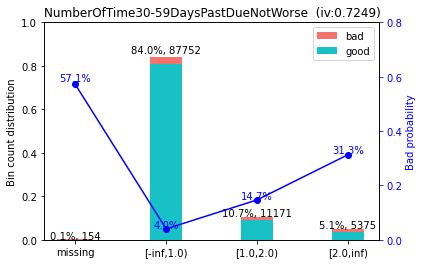

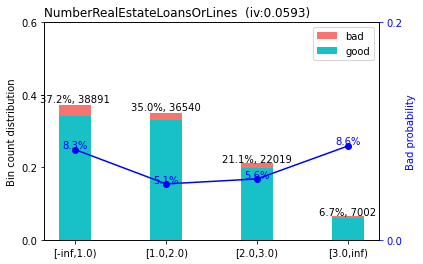

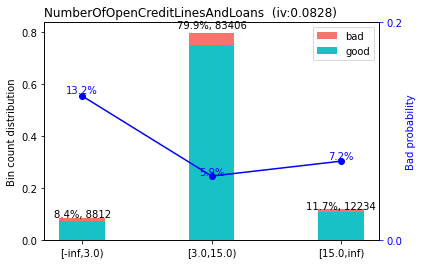

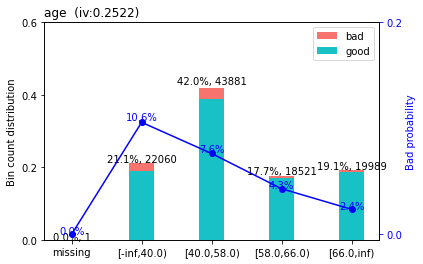

In [316]:
# Смотрим бины
bins = sc.woebin(data, y="SeriousDlqin2yrs")
sc.woebin_plot(bins)

-------- 1/8 DebtRatio --------
>>> dt[DebtRatio].describe(): 
count    104452.000000
mean        356.053455
std        2172.747226
min           0.000000
25%           0.176965
50%           0.368022
75%           0.873129
max      329664.000000
Name: DebtRatio, dtype: float64 



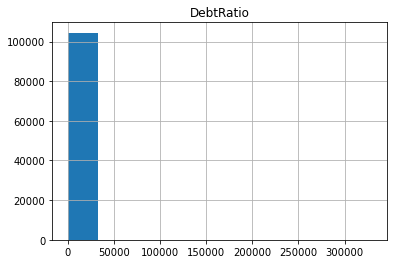

>>> Current breaks:
0.4,0.5,0.6000000000000001,3.0 



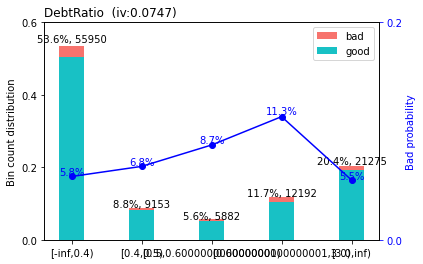

>>> Adjust breaks for (1/8) DebtRatio?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/8 MonthlyIncome --------
>>> dt[MonthlyIncome].describe(): 
count    8.395900e+04
mean     6.689040e+03
std      1.565831e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.250000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64 



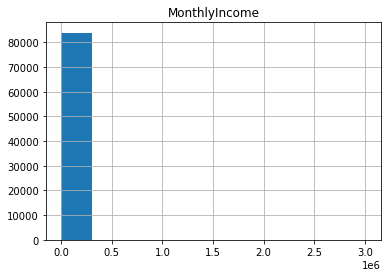

>>> Current breaks:
4000.0,5500.0,10000.0 



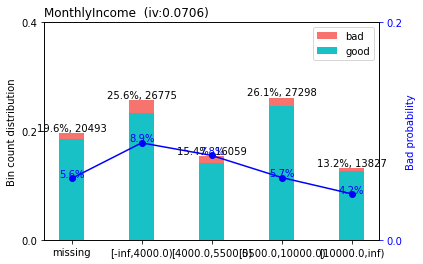

>>> Adjust breaks for (2/8) MonthlyIncome?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/8 NumberOfDependents --------
>>> dt[NumberOfDependents].describe(): 
count    101757.000000
mean          0.758267
std           1.113034
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          13.000000
Name: NumberOfDependents, dtype: float64 



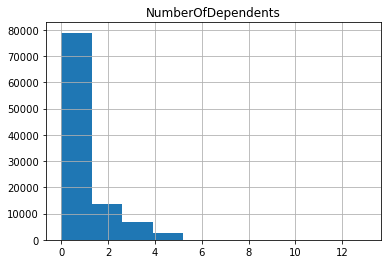

>>> Current breaks:
1.0,2.0,3.0 



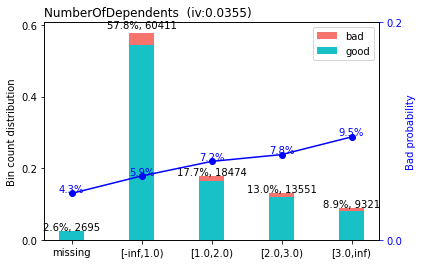

>>> Adjust breaks for (3/8) NumberOfDependents?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/8 NumberOfOpenCreditLinesAndLoans --------
>>> dt[NumberOfOpenCreditLinesAndLoans].describe(): 
count    104452.000000
mean          8.478210
std           5.120052
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64 



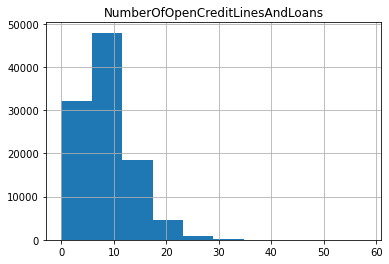

>>> Current breaks:
3.0,15.0 



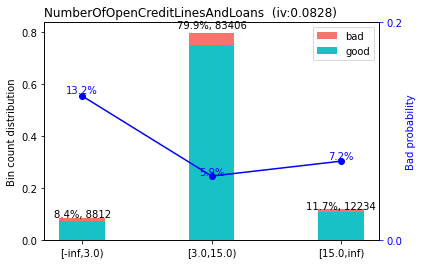

>>> Adjust breaks for (4/8) NumberOfOpenCreditLinesAndLoans?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/8 NumberOfTime30-59DaysPastDueNotWorse --------
>>> dt[NumberOfTime30-59DaysPastDueNotWorse].describe(): 
count    104298.000000
mean          0.246189
std           0.697558
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64 



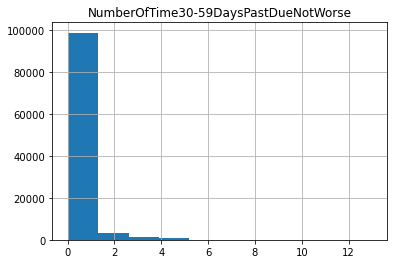

>>> Current breaks:
1.0,2.0 



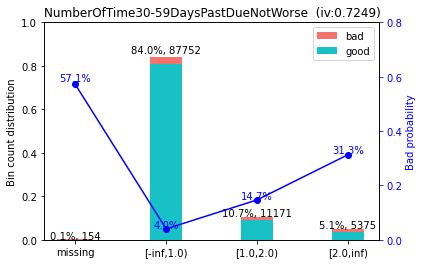

>>> Adjust breaks for (5/8) NumberOfTime30-59DaysPastDueNotWorse?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/8 NumberRealEstateLoansOrLines --------
>>> dt[NumberRealEstateLoansOrLines].describe(): 
count    104452.000000
mean          1.022996
std           1.137218
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64 



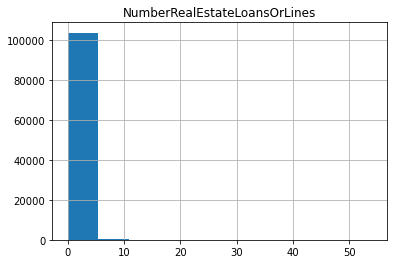

>>> Current breaks:
1.0,2.0,3.0 



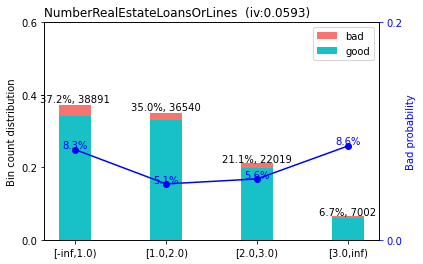

>>> Adjust breaks for (6/8) NumberRealEstateLoansOrLines?
1: next 
2: yes 
3: back
Selection: 1
-------- 7/8 RevolvingUtilizationOfUnsecuredLines --------
>>> dt[RevolvingUtilizationOfUnsecuredLines].describe(): 
count    104452.000000
mean          5.619242
std         217.756704
min           0.000000
25%           0.029997
50%           0.153982
75%           0.557240
max       29110.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64 



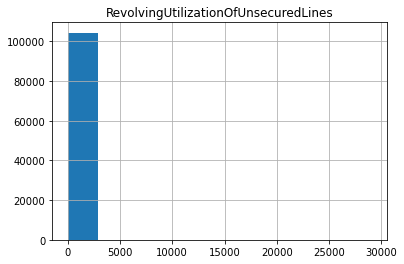

>>> Current breaks:
0.1,0.4,0.8 



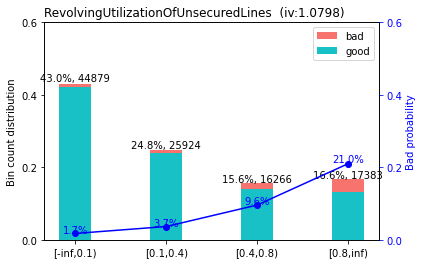

>>> Adjust breaks for (7/8) RevolvingUtilizationOfUnsecuredLines?
1: next 
2: yes 
3: back
Selection: 1
-------- 8/8 money_on_dependent --------
>>> dt[money_on_dependent].describe(): 
count    8.395900e+04
mean     5.498741e+03
std      1.041922e+04
min      0.000000e+00
25%      2.533333e+03
50%      4.280000e+03
75%      6.900000e+03
max      1.794060e+06
Name: money_on_dependent, dtype: float64 



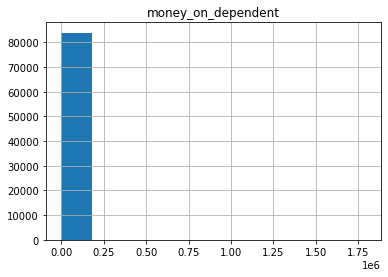

>>> Current breaks:
3000.0,5000.0,7500.0 



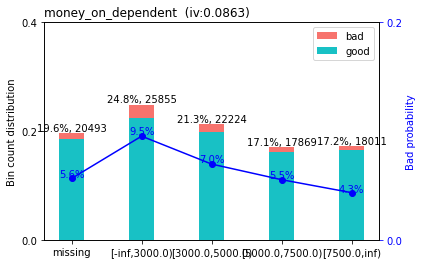

>>> Adjust breaks for (8/8) money_on_dependent?
1: next 
2: yes 
3: back
Selection: 1


In [317]:
# Пробуем некоторые изменения при категоризации для улучшения результата(подбор бинов по умолчанию дал наилучшее качество)
breaks_adj = sc.woebin_adj(data, "SeriousDlqin2yrs", bins)

In [318]:
# Переменные и их бины
breaks_adj

"{'DebtRatio': [0.4,0.5,0.6000000000000001,3.0], 'MonthlyIncome': [4000.0,5500.0,10000.0], 'NumberOfDependents': [1.0,2.0,3.0], 'NumberOfOpenCreditLinesAndLoans': [3.0,15.0], 'NumberOfTime30-59DaysPastDueNotWorse': [1.0,2.0], 'NumberOfTimes90DaysLate': [1.0], 'NumberRealEstateLoansOrLines': [1.0,2.0,3.0], 'RevolvingUtilizationOfUnsecuredLines': [0.1,0.4,0.8], 'age': [40.0,58.0,66.0], 'money_on_dependent': [3000.0,5000.0,7500.0]}"

In [319]:
# Применяем WoE преобразование для тренировочного и тестового наборов данных
bins_adj = sc.woebin(data, y="SeriousDlqin2yrs", breaks_list=breaks_adj)

train_woe = sc.woebin_ply(new_train, bins_adj)
test_woe = sc.woebin_ply(new_test, bins_adj)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [352]:
# Information Value
slovar = {}

for i in bins_adj.keys():
    slovar[i] = round(max(bins_adj[i]['total_iv']), 3)
    
id_table = pd.DataFrame.from_dict(slovar, orient='index', columns=['IV']).sort_values(by='IV', ascending=False)
id_table

,IV
RevolvingUtilizationOfUnsecuredLines,1.080
NumberOfTimes90DaysLate,0.828
NumberOfTime30-59DaysPastDueNotWorse,0.725
age,0.252
money_on_dependent,0.086
NumberOfOpenCreditLinesAndLoans,0.083
DebtRatio,0.075
MonthlyIncome,0.071
NumberRealEstateLoansOrLines,0.059
NumberOfDependents,0.036


In [320]:
# Соединяем в единый фрейм для конечного обучения
data_woe = pd.concat([train_woe, test_woe])

In [321]:
# Разбиваем в ручную
y_train = train_woe.loc[:,'SeriousDlqin2yrs']
X_train = train_woe.loc[:,train_woe.columns != 'SeriousDlqin2yrs']
y_test = test_woe.loc[:,'SeriousDlqin2yrs']
X_test = test_woe.loc[:,train_woe.columns != 'SeriousDlqin2yrs']

In [322]:
# Небольшой подбор гиперпараметров
params_woe = {
              'penalty': ['l2', 'none'],
              'C': [1, 10, 30]}

In [323]:
%%time
gs_lr = GridSearchCV(LogisticRegression(random_state=32, n_jobs=-1),
                     param_grid=params_woe, scoring='roc_auc', cv=5).fit(X_train, y_train)


Wall time: 41.7 s


In [324]:
gs_lr.best_params_

{'C': 1, 'penalty': 'l2'}

In [325]:
# Качество на обучающем наборе
gs_lr.best_score_

0.8480124366745942

In [353]:
y_train_proba = gs_lr.predict_proba(X_train)[:, 1]
y_test_proba = gs_lr.predict_proba(X_test)[:, 1]

# Качество на отложенной выборке
roc_auc_score(y_test, y_test_proba)

0.8503614159647257

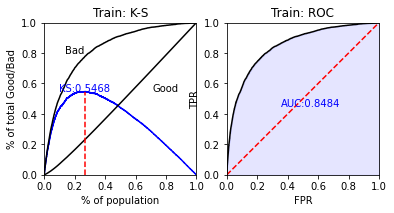

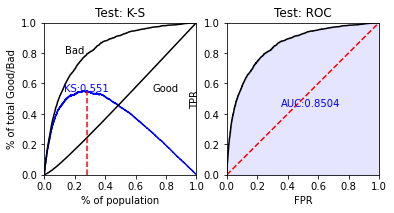

In [354]:
train_perf = sc.perf_eva(y_train, y_train_proba, title='Train')
test_perf = sc.perf_eva(y_test, y_test_proba, title='Test')

In [327]:
# Обучаем конечную модель на полном наборе WoE трансформированных признаков
model = LogisticRegression(C=10, random_state=32, n_jobs=-1).fit(data_woe.iloc[:, 1:], data_woe['SeriousDlqin2yrs'])

In [328]:
# Преобразования тестовго набора
id_test = test.pop('Id')

test.isna().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           8950
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1175
dtype: int64

In [329]:
# Заполним пропущенные значения для тестового набора
test['NumberOfDependents'] = test['NumberOfDependents'].fillna(new_train['NumberOfDependents'].median())
test['MonthlyIncome'] = test['MonthlyIncome'].fillna(new_train['MonthlyIncome'].mean())

In [330]:
# Новая переменная для тестового набора
test['money_on_dependent'] = np.where(test.NumberOfDependents > 0, test.MonthlyIncome / test.NumberOfDependents, test.MonthlyIncome)

In [331]:
# Разница в предикторах между тренировочным и тестовым набором
set(data_woe.columns) - set(res.columns)

{'SeriousDlqin2yrs'}

In [332]:
# Применяем WoE трансформацию на тестовом наборе
res = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...


In [335]:
# Предсказанные вероятности тестового набора данных
predicted = model.predict_proba(res)

In [336]:
submission = pd.DataFrame(id_test,)
submission['SeriousDlqin2yrs'] = predicted[:, 1]
submission

,Id,SeriousDlqin2yrs
0,0,0.320294
1,9,0.047474
2,17,0.022847
3,18,0.040423
4,24,0.010988
...,...,...
45190,149992,0.089533
45191,149994,0.028367
45192,149995,0.008290
45193,149996,0.046728


In [337]:
submission.to_csv('Give me some credit_woe_full.csv', index=False)